In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
class ResNetModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        inputs = layers.Input(shape=self.input_shape)

        x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

        filters = [64, 128, 256, 512]
        num_blocks = [2, 2, 2, 2]

        for i in range(len(filters)):
            for j in range(num_blocks[i]):
                if j == 0 and i != 0:
                    x = self.residual_block(x, filters[i], stride=2)
                else:
                    x = self.residual_block(x, filters[i])

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs, x)
        return model

    def residual_block(self, x, filters, kernel_size=3, stride=1, activation='relu'):
        shortcut = x

        x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

        x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)

        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation(activation)(x)

        return x
    
    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
        train_steps_per_epoch = len(X_train) // batch_size
        val_steps_per_epoch = len(X_val) // batch_size

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Training
            train_loss = 0
            train_accuracy = 0
            for step in range(train_steps_per_epoch):
                batch_X = X_train[step * batch_size:(step + 1) * batch_size]
                batch_y = y_train[step * batch_size:(step + 1) * batch_size]

                loss, accuracy = self.model.train_on_batch(batch_X, batch_y)
                train_loss += loss
                train_accuracy += accuracy

            train_loss /= train_steps_per_epoch
            train_accuracy /= train_steps_per_epoch

            # Validation
            val_loss = 0
            val_accuracy = 0
            for step in range(val_steps_per_epoch):
                batch_X = X_val[step * batch_size:(step + 1) * batch_size]
                batch_y = y_val[step * batch_size:(step + 1) * batch_size]

                loss, accuracy = self.model.test_on_batch(batch_X, batch_y)
                val_loss += loss
                val_accuracy += accuracy

            val_loss /= val_steps_per_epoch
            val_accuracy /= val_steps_per_epoch

            print(f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - "
                  f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        return self.model.predict(X)
    def save_model(self, filepath):
        return self.model.save(filepath)


In [4]:
dataset = np.load('faceClassificationAugDataset.npz')

In [5]:
X, y, labels = dataset['X'], dataset['y'], dataset['labels']

In [6]:
X.shape

(51750, 224, 224, 3)

In [7]:
prep = list(zip(X,y))
np.random.shuffle(prep)

In [8]:
X, y = zip(*prep)

In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
X.shape

(51750, 224, 224, 3)

In [11]:
trainSize = int(0.8*len(X))

X_train, X_val = X[:trainSize], X[trainSize:]
y_train, y_val = y[:trainSize], y[trainSize:]

# One-hot encode the labels
num_classes = len(labels)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# # Ensure correct data types
# X_train = X_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# y_train = y_train.astype(np.float32)
# y_val = y_val.astype(np.float32)

In [12]:
input_shape = (224, 224, 3)

model = ResNetModel(input_shape, num_classes)
model.compile_model()
model.train(X_train, y_train, X_val, y_val, batch_size=64, epochs=10)

Epoch 1/10
Train Loss: 7.0999 - Train Accuracy: 0.0115 - Val Loss: 7.3153 - Val Accuracy: 0.0069
Epoch 2/10
Train Loss: 5.1954 - Train Accuracy: 0.0986 - Val Loss: 4.6258 - Val Accuracy: 0.1576
Epoch 3/10
Train Loss: 2.8038 - Train Accuracy: 0.4292 - Val Loss: 2.4996 - Val Accuracy: 0.4819
Epoch 4/10
Train Loss: 1.3070 - Train Accuracy: 0.7189 - Val Loss: 1.3838 - Val Accuracy: 0.7078
Epoch 5/10
Train Loss: 0.6398 - Train Accuracy: 0.8609 - Val Loss: 0.9661 - Val Accuracy: 0.7887
Epoch 6/10
Train Loss: 0.3318 - Train Accuracy: 0.9288 - Val Loss: 0.7220 - Val Accuracy: 0.8431
Epoch 7/10
Train Loss: 0.1855 - Train Accuracy: 0.9615 - Val Loss: 0.7640 - Val Accuracy: 0.8290
Epoch 8/10
Train Loss: 0.1145 - Train Accuracy: 0.9757 - Val Loss: 0.5465 - Val Accuracy: 0.8872
Epoch 9/10
Train Loss: 0.1015 - Train Accuracy: 0.9768 - Val Loss: 0.7093 - Val Accuracy: 0.8593
Epoch 10/10
Train Loss: 0.1054 - Train Accuracy: 0.9724 - Val Loss: 0.6135 - Val Accuracy: 0.8709


In [13]:
model.save_model('faceClassificationAug.keras')

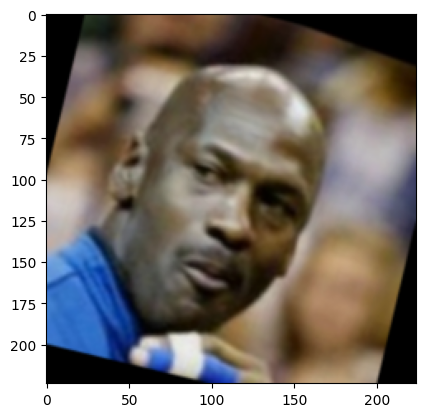

In [33]:
plt.imshow(X_val[4])

In [16]:
prediction = model.predict(X_val[0:10])

1/1 [==============================] - 1s 615ms/step


In [34]:
pred1 = prediction[4]

In [35]:
pred1Index = np.where(pred1 == pred1.max())[0]
print(labels[pred1Index])

['Sergei_Ivanov']
